# Lottery Ticket Hypothesis

* Instructions
* Ref lists etc

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

import urllib.request
from livelossplot import PlotLosses

## Data loading

In [3]:
# adding more classes may make it better
classes = ["cat", "dog", "spider", "octopus", "snowflake"]

In [ ]:
!mkdir data

In [ ]:
# download classes in necessary
base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
for c in classes:
    path = '{}{}.npy'.format(base_url, c.replace('_', '%20'))
    print(path)
    urllib.request.urlretrieve(path, "data/{}.npy".format(c))

In [4]:
limit = 500  # to make i faster & more less easy for memorization 

X_list = []

for c in classes:
    X_c = np.load("data/{}.npy".format(c))  # or "../data/full_numpy_bitmap_{}.npy"
    print("Loaded {} out of {} {}s".format(limit, X_c.shape[0], c))
    X_list.append(X_c[:limit])

X = np.concatenate(X_list)
Y = np.concatenate([limit * [i] for i in range(len(classes))])

Loaded 500 out of 123202 cats
Loaded 500 out of 152159 dogs
Loaded 500 out of 209447 spiders
Loaded 500 out of 150152 octopuss
Loaded 500 out of 116685 snowflakes


In [5]:
size = 32

X = X.reshape(-1, 1, 28, 28)
X = X.astype('float32') / 255.

# but it is so much easier to work with 32x32 images
X = np.pad(X, [(0, 0), (0, 0), (2, 2), (2, 2)], mode='constant', constant_values=0)

# (samples, channels, x, y)
X.shape

(2500, 1, 32, 32)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [7]:
def draw_examples(X, Y, classes, rows=6, scale=1):
    fig, axs = plt.subplots(rows, len(classes), figsize=(scale * len(classes), scale * rows))
    size = X.shape[-1]
    for class_id in range(len(classes)):
        X_class = X[Y == class_id]
        for i in range(rows):
            ax = axs[i, class_id]
            x = X_class[np.random.randint(len(X_class))].reshape(size, size)
            ax.imshow(x, cmap='Greys', interpolation='none')
            ax.axis('off')

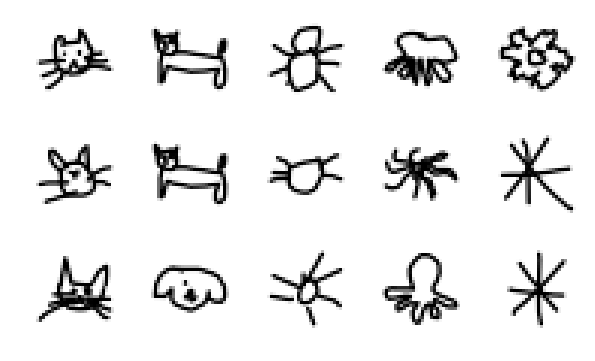

In [8]:
draw_examples(X_train, Y_train, classes, rows=3, scale=2)

In [9]:
# define data loaders
dataloaders = {
    'train':
    DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train).long()),
               batch_size=64,
               shuffle=True, num_workers=4),
    'validation': 
    DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test).long()),
               batch_size=64,
               shuffle=False, num_workers=4)
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels.data).sum().item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        
        liveloss.update(logs)
        liveloss.draw()

## Models

### Logistic regression baseline

In [10]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(size**2, len(classes))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

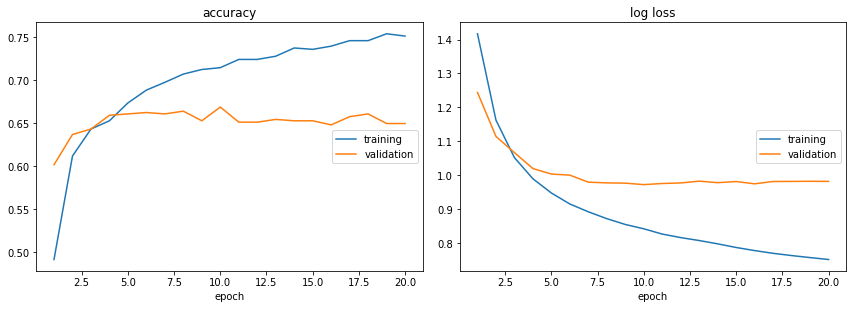

accuracy:
training   (min:    0.491, max:    0.754, cur:    0.751)
validation (min:    0.602, max:    0.669, cur:    0.650)

log loss:
training   (min:    0.753, max:    1.417, cur:    0.753)
validation (min:    0.973, max:    1.244, cur:    0.982)


In [11]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

### MLP (2 hidden layers)

* normal
* signals + fixed gates
* only linear

In [55]:
class MLP(nn.Module):
    def __init__(self, hidden_1=128,):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1 * size * size, hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, len(classes))
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model = MLP(hidden_1=2048)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

In [76]:


# same as MLP. but linear gates
class MLPLin(nn.Module):
    def __init__(self, hidden_1=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1 * size * size, hidden_1),
            nn.Linear(hidden_1, hidden_1),
            nn.Linear(hidden_1, len(classes))
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class MLPLinGate(nn.Module):
    def __init__(self, hidden_1=128, gate_grads=False, same_initial_weights=False):
        super().__init__()

        self.fc1_lin = nn.Linear(1 * size * size, hidden_1)
        self.fc1_gate = nn.Linear(1 * size * size, hidden_1)
        if same_initial_weights:
            self.fc1_gate.weight.data.copy_(self.fc1_lin.weight.data)
            self.fc1_gate.bias.data.copy_(self.fc1_lin.bias.data)
        for param in self.fc1_gate.parameters():
            param.requires_grad = gate_grads
        
        self.fc2_lin = nn.Linear(hidden_1, hidden_1)
        self.fc2_gate = nn.Linear(hidden_1, hidden_1)
        if same_initial_weights:
            self.fc2_gate.weight.data.copy_(self.fc2_lin.weight.data)
            self.fc2_gate.bias.data.copy_(self.fc2_lin.bias.data)
        for param in self.fc2_gate.parameters():
            param.requires_grad = gate_grads
            
        self.fc3_lin = nn.Linear(hidden_1, len(classes))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        # same input for both
        g = self.fc1_gate(x).relu()
        x = self.fc1_lin(x) * (g > 0).float()
        
        # snow different
        g = self.fc2_gate(g).relu()
        x = self.fc2_lin(x) * (g > 0).float()      
        
        return  self.fc3_lin(x)

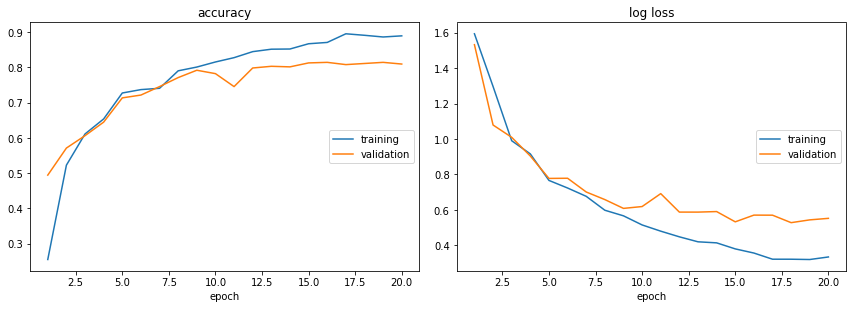

accuracy:
training   (min:    0.255, max:    0.895, cur:    0.890)
validation (min:    0.494, max:    0.814, cur:    0.810)

log loss:
training   (min:    0.319, max:    1.594, cur:    0.334)
validation (min:    0.527, max:    1.533, cur:    0.552)


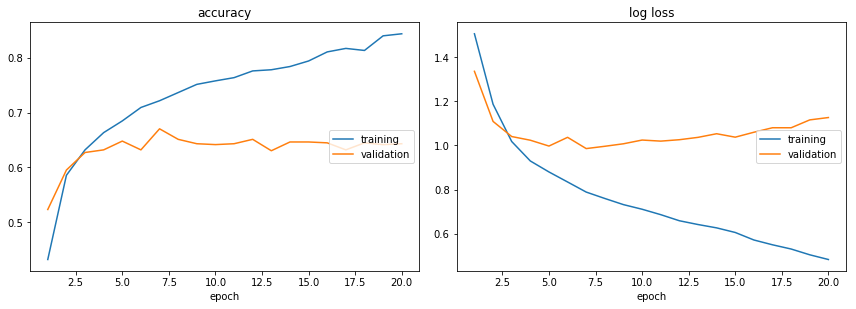

accuracy:
training   (min:    0.432, max:    0.844, cur:    0.844)
validation (min:    0.523, max:    0.670, cur:    0.643)

log loss:
training   (min:    0.483, max:    1.506, cur:    0.483)
validation (min:    0.986, max:    1.336, cur:    1.126)


In [78]:
# some baseline
model = MLP(hidden_1=32)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

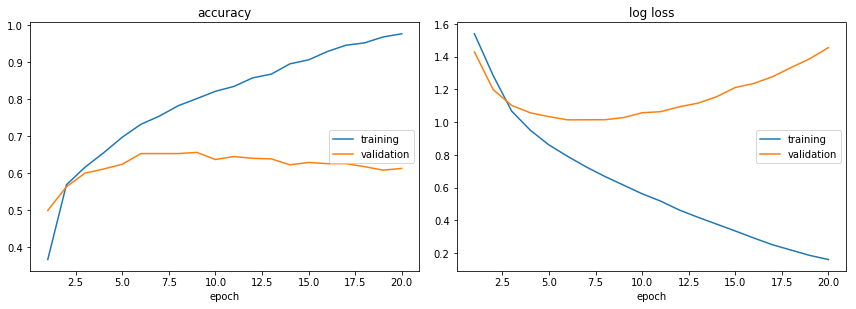

accuracy:
training   (min:    0.367, max:    0.976, cur:    0.976)
validation (min:    0.499, max:    0.656, cur:    0.613)

log loss:
training   (min:    0.161, max:    1.540, cur:    0.161)
validation (min:    1.014, max:    1.456, cur:    1.456)


In [58]:
# the actual
model = MLPLinGate(hidden_1=32)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

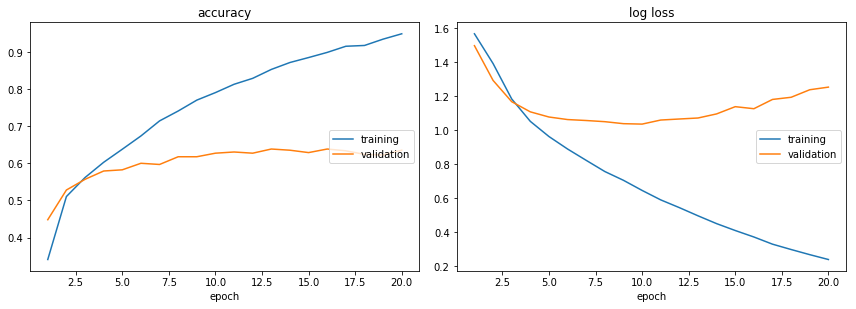

accuracy:
training   (min:    0.341, max:    0.949, cur:    0.949)
validation (min:    0.448, max:    0.638, cur:    0.635)

log loss:
training   (min:    0.238, max:    1.566, cur:    0.238)
validation (min:    1.035, max:    1.496, cur:    1.252)


In [61]:
model = MLPLinGate(hidden_1=32, gate_grads=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

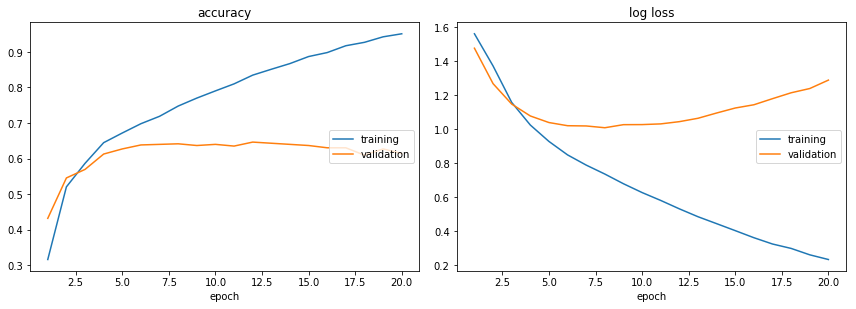

accuracy:
training   (min:    0.316, max:    0.951, cur:    0.951)
validation (min:    0.432, max:    0.646, cur:    0.614)

log loss:
training   (min:    0.231, max:    1.560, cur:    0.231)
validation (min:    1.007, max:    1.475, cur:    1.287)


In [81]:
# same initial weights
# this one gives similar results
model = MLPLinGate(hidden_1=32, same_initial_weights=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

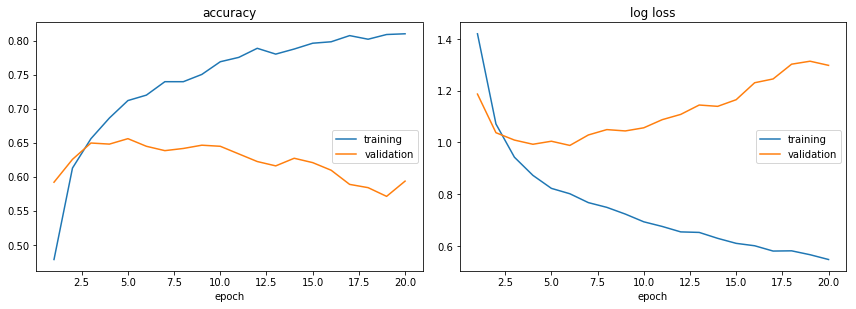

accuracy:
training   (min:    0.478, max:    0.810, cur:    0.810)
validation (min:    0.571, max:    0.656, cur:    0.594)

log loss:
training   (min:    0.548, max:    1.420, cur:    0.548)
validation (min:    0.989, max:    1.314, cur:    1.298)


In [57]:
# to compare with a linear model
model = MLPLin(hidden_1=32)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

## LinGate module

To do: couple 

* Make it possible to relate initalizaiton
* Create LinGateSequential for connecting

In [16]:
class LinGate(nn.Module):
    def __init__(self, layer_lin, layer_gate, copy_weights=False):
        super().__init__()
        
        self.L = layer_lin
        self.G = layer_gate
        
        if copy_weights:
            self.G.weight.data.copy_(self.L.weight.data)
            self.G.bias.data.copy_(self.L.bias.data)
        
        for param in self.G.parameters():
            param.requires_grad = False
  
    def forward(self, lin_in, gate_in):
        gate_out = self.G(gate_in).relu()
        lin_out = self.L(lin_in) * (gate_out > 0).float()
        
        return lin_out, gate_out
    
class DoubleSequential(nn.Module):
    def __init__(self, *module_sequence):
        super().__init__()
        self.module_sequence = module_sequence
        
    
    def forward(self, lin_in, gate_in):
        lin, gate = lin_in, gate_in
        for module in self.module_sequence:
            lin, gate = module(lin, gate)
        return lin, gate

## ConvNet, VGG-like

* normal
* linear (AvgPool)
* lin gate in progress


Questions: how to avoid MaxPool? AvgPool or strided convolution?

In [26]:
# a convnet
class ConvNet(nn.Module):
    def __init__(self, pooling=nn.AvgPool2d(2, 2)):
        super().__init__()
        self.pooling = pooling
        self.convs = nn.Sequential(
            self._block(1, 16),
            self._block(16, 32),
            self._block(32, 32),
            self._block(32, 32)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 2 * 2, len(classes)) # dropout between dense layers
        )
        
    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),  # batch norm 2d
            self.pooling
        )
    
    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x.view(x.size(0), -1))
        return x

# a convnet
    
# or we can modularize that
class ConvNetLin(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            self._block(1, 16),
            self._block(16, 32),
            self._block(32, 32),
            self._block(32, 32)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 2 * 2, len(classes)) # dropout between dense layers
        )
        
    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            # no ReLU
            nn.AvgPool2d(2, 2)  # instead of MaxPool, which itself is a non-linearity
        )
    
    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x.view(x.size(0), -1))
        return x


class ConvNetLinGate(nn.Module):
    def __init__(self):
        super().__init__()
        # module list
        self.doubleconvs = DoubleSequential(
            self._doubleblock(1, 16),
            self._doubleblock(16, 32),
            self._doubleblock(32, 32),
            self._doubleblock(32, 32)
        )
        # since linear, no gate here
        self.fc = nn.Sequential(
            nn.Linear(32 * 2 * 2, len(classes)) # dropout between dense layers
        )
        
    def _doubleblock(self, in_channels, out_channels):
        return DoubleSequential(
            LinGate(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                copy_weights=True),
            LinGate(
                nn.AvgPool2d(2, 2),
                nn.AvgPool2d(2, 2),
                copy_weights=False)
        )
    
    def forward(self, x):
        x, g = self.doubleconvs(x, x)
        x = self.fc(x.view(x.size(0), -1))
        return x

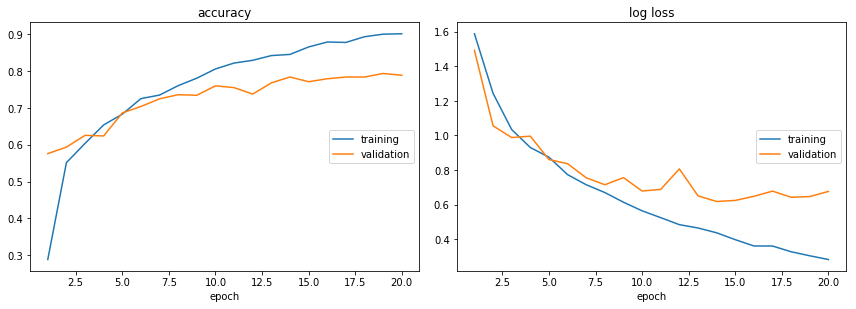

accuracy:
training   (min:    0.289, max:    0.901, cur:    0.901)
validation (min:    0.576, max:    0.794, cur:    0.789)

log loss:
training   (min:    0.282, max:    1.588, cur:    0.282)
validation (min:    0.618, max:    1.492, cur:    0.676)


In [20]:
model = ConvNet(pooling=nn.MaxPool2d(2, 2))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

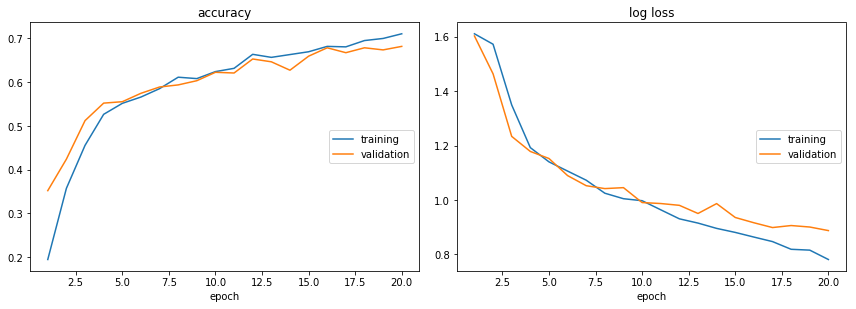

accuracy:
training   (min:    0.195, max:    0.710, cur:    0.710)
validation (min:    0.352, max:    0.682, cur:    0.682)

log loss:
training   (min:    0.781, max:    1.611, cur:    0.781)
validation (min:    0.888, max:    1.603, cur:    0.888)


In [21]:
# avg pool
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

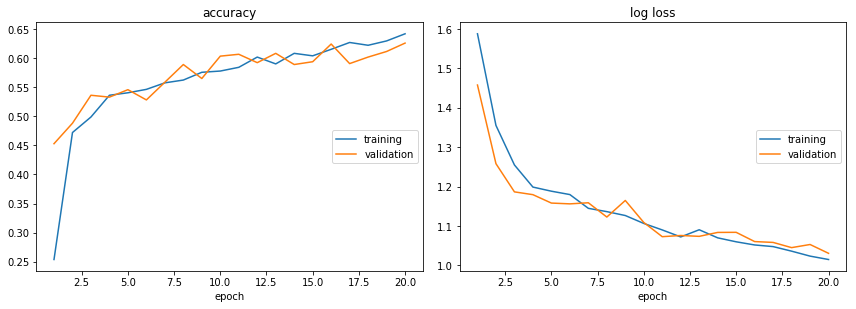

accuracy:
training   (min:    0.254, max:    0.642, cur:    0.642)
validation (min:    0.453, max:    0.626, cur:    0.626)

log loss:
training   (min:    1.015, max:    1.588, cur:    1.015)
validation (min:    1.031, max:    1.458, cur:    1.031)


In [22]:
model = ConvNetLin()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

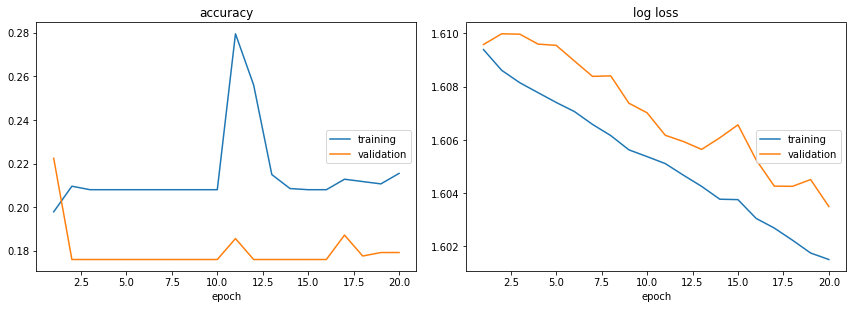

accuracy:
training   (min:    0.198, max:    0.279, cur:    0.215)
validation (min:    0.176, max:    0.222, cur:    0.179)

log loss:
training   (min:    1.601, max:    1.609, cur:    1.601)
validation (min:    1.603, max:    1.610, cur:    1.603)


In [39]:
# for some reason, it does not work
model = ConvNetLinGate()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model(model, criterion, optimizer, num_epochs=20)

In [37]:
model.doubleconvs.module_sequence[0].module_sequence[0].L.weight.grad

tensor([[[[-2.5477e-02, -3.7312e-02, -5.0486e-02],
          [-4.4564e-03, -1.9502e-02, -5.9493e-02],
          [-8.9541e-03, -1.4511e-02, -5.2286e-02]]],


        [[[ 4.8321e-04,  3.8347e-04,  3.0879e-03],
          [ 9.9126e-04,  3.3587e-04,  3.0450e-03],
          [ 2.7773e-03,  7.2605e-04,  2.8513e-03]]],


        [[[-1.4367e-03, -1.1946e-03, -5.2796e-03],
          [-9.1038e-03, -1.3017e-02, -1.7641e-02],
          [-2.3340e-02, -2.6009e-02, -2.8813e-02]]],


        [[[-4.1193e-02, -3.1354e-02, -3.7243e-02],
          [-4.4602e-02, -5.0079e-02, -4.7124e-02],
          [-5.3865e-02, -5.9180e-02, -5.0813e-02]]],


        [[[-5.7730e-03, -8.9304e-03, -1.5648e-02],
          [-4.5686e-03, -9.8938e-03, -1.4640e-02],
          [-1.3210e-02, -1.0603e-02, -1.0326e-02]]],


        [[[-1.3706e-01, -1.4633e-01, -1.4872e-01],
          [-1.3146e-01, -1.3788e-01, -1.3449e-01],
          [-1.0891e-01, -1.1133e-01, -1.0667e-01]]],


        [[[ 5.9227e-02,  4.1053e-02,  1.0496e-02],
       

In [38]:
model.doubleconvs.module_sequence[0].module_sequence[0].G.weight.grad